# Bird Species Classification:
### Using Computer Vision to Classify 525 Different Bird Species
By: David Hartsman and Heath Jones

<hr style="border: 4px solid blue">

This notebook will contain different iterations of neural networks designed to maximize predictive accuracy. The training, validation, and test data sets remain the same as the previous notebook. There are 525 different bird species found in the data. The training data contains variable numbers of images for each bird species, with the minimum count still being more than 100 distinct images. The validation and test sets contain 5 images of each of the 525 different species. 

Throughout this project, we learned a great deal about the `"EfficientNet"` CNN architecture. We did our best to mimic some of that model's blocks with moderate success. The EfficientNet is designed to predict classes with tremendous accuracy while also minimizing the total number of trainable parameters.

Our attempts to create a model from scratch were mildly successful. Ultimately, we were somewhat limited by our computational resources. We did gradually incorporate new elements to each of the 4 original iterations analyzed in this notebook. We created our final model based on the pre-trained model provided by Kaggle, however. Our contributions to that final model were only the final layers. 

This notebook is a record of the modeling process. If you are interested in some of the images of the birds, predictions, and errors, please take a look at our [first notebook](https://github.com/dvdhartsman/Bird_Species_Image_Classification/blob/main/Bird_Classification_1.ipynb) for this project. 

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

import tensorflow as tf
# To streamline the naming, batch generation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Keras model types and layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Metrics for classification
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Recall, Precision

import wandb
from wandb.keras import WandbCallback

import warnings
warnings.filterwarnings("ignore")

2024-02-18 15:38:45.104178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Local path containing train/valid/test folders

path = "/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive"

# 1st set of parameters for model that achieved 44% accuracy after 20 epochs of training
# image_generator = ImageDataGenerator(
#     rescale=1./255,  # Normalize pixel values to [0,1]
#     rotation_range=20,  # Randomly rotate images by up to 20 degrees
#     width_shift_range=0.2,  # Randomly shift images horizontally
#     height_shift_range=0.2,  # Randomly shift images vertically
#     shear_range=0.2,  # Shear intensity
#     zoom_range=0.2,  # Randomly zoom images
#     horizontal_flip=True,  # Randomly flip images horizontally
#     fill_mode='nearest'  # Fill in missing pixels with the nearest value

# Default values except for 'rescale', validation_split == 0 because we have separate validation data

image_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rescale=1/255,  # This argument is still being utilized to scale data from 0 - 1
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",  # still the same
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None)


In [3]:
# Train Generator
train_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "train"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

# Validation
valid_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "valid"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

#Test
test_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "test"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

## Docstring defaults
# image_generator.flow_from_directory(
#     directory,
#     target_size=(256, 256),
#     color_mode='rgb',
#     classes=None,
#     class_mode='categorical',
#     batch_size=32,
#     shuffle=True,
#     seed=None,
#     save_to_dir=None,
#     save_prefix='',
#     save_format='png',
#     follow_links=False,
#     subset=None,
#     interpolation='nearest',
#     keep_aspect_ratio=False,

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [4]:
# The labels for the image data
class_indices = train_generator.class_indices
reverse_dict = {val:key for key, val in class_indices.items()}

In [5]:
# Verifying dictionary construction
class_indices["OILBIRD"], reverse_dict[366],

(366, 'OILBIRD')

<hr style="border: 2px solid blue">

### Keras Convolutional Neural Network Model Creation
This is the second model that we created for this project, the first being found in the previous notebook.

In [6]:
# Instantiate sequential model
model = Sequential()

# Add convolutional layer with pooling
model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1), input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D())

# 2nd convolutional layer
model.add(Conv2D(12, (2,2), (1,1), activation="relu"))
model.add(MaxPooling2D())

# Flatten into a scaler
model.add(Flatten())

# Dense layer
model.add(Dense(192, activation = 'relu'))

# Dense output layer
model.add(Dense(525, activation="softmax"))

2024-02-09 21:56:22.595318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Model Compilation

model.compile(optimizer="adam", loss="categorical_crossentropy", \
              metrics=["accuracy"])

In [8]:
# Summary of the Model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 12)      780       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 12)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 36300)             0         
                                                                 
 dense (Dense)               (None, 192)               6

In [9]:
# Fitting the model

histoy = model.fit(train_generator, epochs=20, validation_data=valid_generator, workers=6)


# 1st model from previous notebook
# hist = model.fit(data_generator, epochs=20, validation_data=valid_generator, callbacks=[tensorboard_callback],\
#                  workers=6)

Epoch 1/20
2645/2645 [==============================] - 787s 297ms/step - loss: 4.8926 - accuracy: 0.0928 - val_loss: 3.7699 - val_accuracy: 0.2168
Epoch 2/20
2645/2645 [==============================] - 1582s 598ms/step - loss: 3.5795 - accuracy: 0.2493 - val_loss: 3.2601 - val_accuracy: 0.2907
Epoch 3/20
2645/2645 [==============================] - 765s 289ms/step - loss: 3.0663 - accuracy: 0.3320 - val_loss: 3.0430 - val_accuracy: 0.3280
Epoch 4/20
2645/2645 [==============================] - 912s 345ms/step - loss: 2.6965 - accuracy: 0.3948 - val_loss: 3.1217 - val_accuracy: 0.3295
Epoch 5/20
2645/2645 [==============================] - 790s 299ms/step - loss: 2.3589 - accuracy: 0.4529 - val_loss: 3.0393 - val_accuracy: 0.3417
Epoch 6/20
2645/2645 [==============================] - 890s 336ms/step - loss: 2.0273 - accuracy: 0.5147 - val_loss: 3.2241 - val_accuracy: 0.3272
Epoch 7/20
2645/2645 [==============================] - 785s 297ms/step - loss: 1.7102 - accuracy: 0.5767 - val

In [137]:
# Saving the second model

histoy.model.save('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/models/bird_classifier_2.h5')

<hr style="border: 3px solid blue">

### Stripped-down model evaluation:
This model clearly suffers from over-fitting. While our initial model topped out in the 40%s for training and validation accuracy, the model generalized on validation images with same accuracy as its training performance. For this model, the training accuracy was around 70% higher than its validation accuracy. This is unacceptably over-fit, and is indicative of a model with terribly generalization capability. This model is effectively unusable. 

In [54]:
# Creating a df from this model's training history object

# model_df = pd.DataFrame(histoy.history)
# model_df["Epochs"] = range(1, 21)
# model_df["Name"] = "Model 2"
# model_df.to_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_2_logs.csv')
model_df = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_2_logs.csv', index_col=0)
model_df.head()

,loss,accuracy,val_loss,val_accuracy,Epochs,Name
0,4.892591,0.092846,3.769941,0.216762,1,Model 2
1,3.579454,0.249282,3.260067,0.290667,2,Model 2
2,3.066257,0.332038,3.042955,0.328000,3,Model 2
3,2.696495,0.394789,3.121729,0.329524,4,Model 2
4,2.358895,0.452933,3.039319,0.341714,5,Model 2


In [55]:
# Importing data from the model created in the previous notebook

first_model = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_1_logs.csv', index_col=0)
first_model["Name"] = "Model 1"
first_model = first_model.reindex(columns=model_df.columns)
first_model.head()

,loss,accuracy,val_loss,val_accuracy,Epochs,Name
0,5.677375,0.020193,5.195110,0.044571,1,Model 1
1,4.914515,0.075772,4.407012,0.119619,2,Model 1
2,4.315264,0.145401,4.062500,0.180571,3,Model 1
3,3.901346,0.202280,3.577578,0.237333,4,Model 1
4,3.620565,0.244249,3.382480,0.275048,5,Model 1


<hr style="border: 3px solid blue">

### Plotting functions

In [56]:
def plot_history_comparisons(dfs:list, metrics:str):
    """
    Compare one performance metric between 2 or more models
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(nrows=len(dfs), figsize=(12,7), gridspec_kw={"hspace":.5})
    for idx, df in enumerate(dfs):
        sns.lineplot(data=df, x="Epochs", y=metrics, ax=ax[idx], label=f"Train {metrics.title()}")
        sns.lineplot(data=df, x="Epochs", y=f"val_{metrics}", ax=ax[idx], label= f"Validation {metrics.title()}",\
                    linestyle="--")
        
        ax[idx].set_title(f"Training vs Validation {metrics.title()} for {df['Name'][0]}")
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_xticks(range(1,21))
        if metrics == "loss":
            ax[idx].set_ylabel(f"{metrics.title()} (Categorical Crossentropy)")
        else:
            ax[idx].set_ylabel(f"{metrics.title()}")
        ax[idx].legend()

In [63]:
def compare_models_same_plot(dfs:list, metrics=["accuracy", "loss"], train_only=False, val_only=False):
    # Style options
    palette = ["red", "green", "darkorange", "blue"]
    sns.set_style("darkgrid")
    
    # Figure Creation
    fig, ax = plt.subplots(nrows=len(metrics), figsize=(12,9), gridspec_kw={"hspace":.3})
    
    # Loop creating separate plots for accuracy and loss
    for idx, m in enumerate(metrics):
        for i, df in enumerate(dfs):
            # Selecting polar opposite colors to compare models
            color = palette[0 - i]
            
            # Plot train/val for each model df in the loop
            if not val_only:
                sns.lineplot(data=df, x="Epochs", y=m, ax=ax[idx], \
                             label=f"Train {m.title()} for {dfs[i]['Name'][0]}", c=color)
            if not train_only:
                sns.lineplot(data=df, x="Epochs", y=f"val_{m}", ax=ax[idx], \
                             label=f"Validation {m.title()} for {dfs[i]['Name'][0]}", c=color, linestyle="--")
        
        # After completing the loop, format the subplot appropriately
        ax[idx].set_title(f"Training and Validation {m.title()} for {[dfs[i]['Name'][0] for i in range(len(dfs))]} ")
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_xticks(range(1,21))
        if m == "loss":
            ax[idx].set_ylabel(f"{m.title()} (Categorical Crossentropy)")
        else:
            ax[idx].set_ylabel(f"{m.title()}")
        ax[idx].legend()
    names = [dfs[i]["Name"][0] for i in range(len(dfs)-1)]
    if len(names) > 1:
        names = " vs ".join(names)
    else:
        names = " ".join(names)
    plt.suptitle(f"Comparison of {names} vs {dfs[-1]['Name'][0]}", y=.95, fontsize=18)

<hr style="border: 3px solid blue">

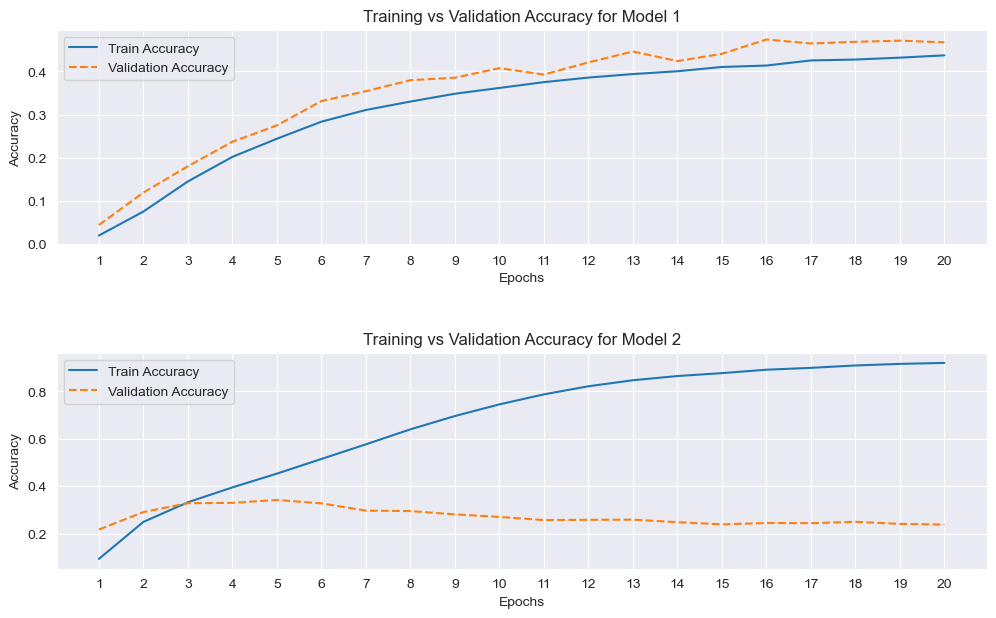

In [58]:
# Plot both metrics for both dfs -> accuracy first

plot_history_comparisons([first_model, model_df], metrics='accuracy')

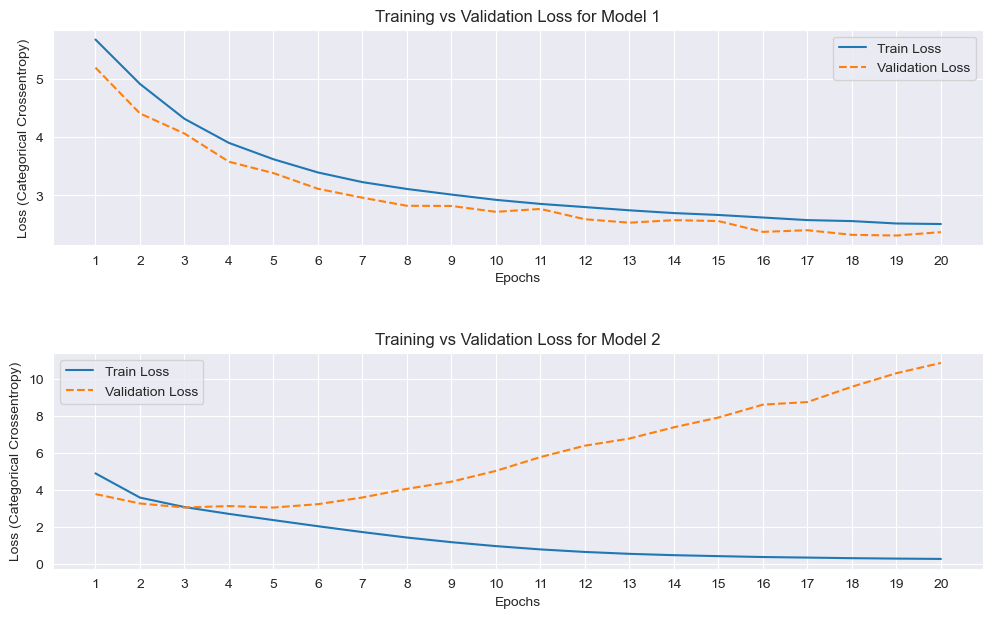

In [59]:
# Loss plot for both models

plot_history_comparisons([first_model, model_df], metrics='loss')

As you can see, the second model exhibits all of the characteristics of being over-fit. There is a huge divergence between training metrics and validation metrics. Where the first model never achieved an adequate level of accuracy, it was able to generalize on par with its training accuracy. It is conceivable that if the first model was allowed to train for many more epochs, perhaps it could have attained more respectable levels of accuracy, as the EfficientNet solution at the bottom of this notebook was trained over 150 epochs. Regardless, additional tuning is required.

<hr style="border:4px solid blue">

### Third model creation

In [15]:
# Define custom functions for precision, recall, and F1-score

def precision(y_true, y_pred):
    precision = Precision()
    precision.update_state(y_true, y_pred)
    return precision.result()

def recall(y_true, y_pred):
    recall = Recall()
    recall.update_state(y_true, y_pred)
    return recall.result()

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))

In [19]:
# Third model composition

model3 = Sequential()

model3.add(Conv2D(filters=16, kernel_size=(2,2), strides=1, input_shape=(224,224,3), activation="relu"))
model3.add(MaxPooling2D())

model3.add(Conv2D(filters=12, kernel_size=(2,2), strides=1, activation="relu"))
model3.add(MaxPooling2D())

# This is the first model with a 3rd convolutional layer
model3.add(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation="relu"))
model3.add(MaxPooling2D())

# This is the first model with a 4th convolutional layer
model3.add(Conv2D(filters=8, kernel_size=(2,2), strides=1, activation="relu"))
model3.add(MaxPooling2D())

model3.add(Flatten())
model3.add(Dense(124, activation="relu"))
model3.add(Dense(525, activation="softmax"))

# Model Compilation

model3.compile(optimizer="adam", loss="categorical_crossentropy", \
              metrics=["accuracy"])

In [20]:
# Display of the model architecture 

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 223, 223, 16)      208       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 110, 110, 12)      780       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 55, 55, 12)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 54, 54, 8)         392       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 27, 27, 8)       

In [21]:
# Training the model

history_3 = model3.fit(train_generator, epochs=20, validation_data=valid_generator, workers=6)

Epoch 1/20
2645/2645 [==============================] - 750s 283ms/step - loss: 4.8968 - accuracy: 0.1073 - val_loss: 3.6216 - val_accuracy: 0.2499
Epoch 2/20
2645/2645 [==============================] - 763s 289ms/step - loss: 3.4233 - accuracy: 0.2905 - val_loss: 3.0501 - val_accuracy: 0.3459
Epoch 3/20
2645/2645 [==============================] - 1391s 526ms/step - loss: 2.9255 - accuracy: 0.3750 - val_loss: 2.6606 - val_accuracy: 0.4103
Epoch 4/20
2645/2645 [==============================] - 1449s 548ms/step - loss: 2.6256 - accuracy: 0.4263 - val_loss: 2.5570 - val_accuracy: 0.4370
Epoch 5/20
2645/2645 [==============================] - 797s 301ms/step - loss: 2.4156 - accuracy: 0.4625 - val_loss: 2.5003 - val_accuracy: 0.4514
Epoch 6/20
2645/2645 [==============================] - 780s 295ms/step - loss: 2.2570 - accuracy: 0.4911 - val_loss: 2.4193 - val_accuracy: 0.4655
Epoch 7/20
2645/2645 [==============================] - 3178s 1s/step - loss: 2.1293 - accuracy: 0.5155 - val_

In [60]:
# Dataframe for 3rd model metrics

# model3_df = pd.DataFrame(history_3.history)
# model3_df["Epochs"] = range(1, 21)
# model3_df["Name"] = "Model 3"

# model3_df.to_csv("/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_3_logs.csv")
model3_df = pd.read_csv("/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_3_logs.csv", index_col=0)
model3_df.head()

,loss,accuracy,val_loss,val_accuracy,Epochs,Name
0,4.8968,0.1073,3.6216,0.2499,1,Model 3
1,3.4233,0.2905,3.0501,0.3459,2,Model 3
2,2.9255,0.3750,2.6606,0.4103,3,Model 3
3,2.6256,0.4263,2.5570,0.4370,4,Model 3
4,2.4156,0.4625,2.5003,0.4514,5,Model 3


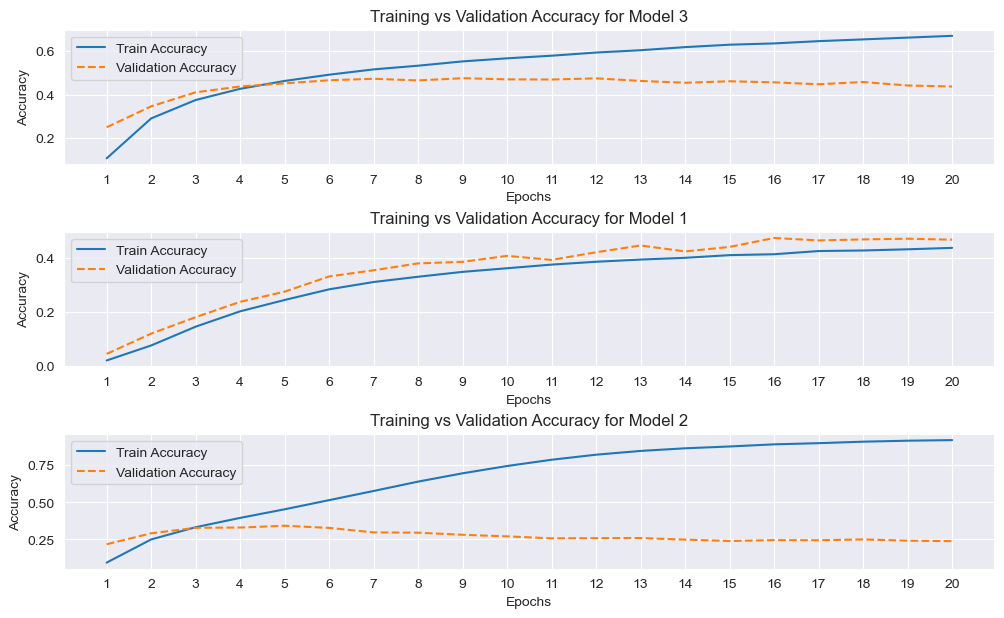

In [132]:
# Plotting for comparison

plot_history_comparisons([model3_df, first_model, model_df], "accuracy")

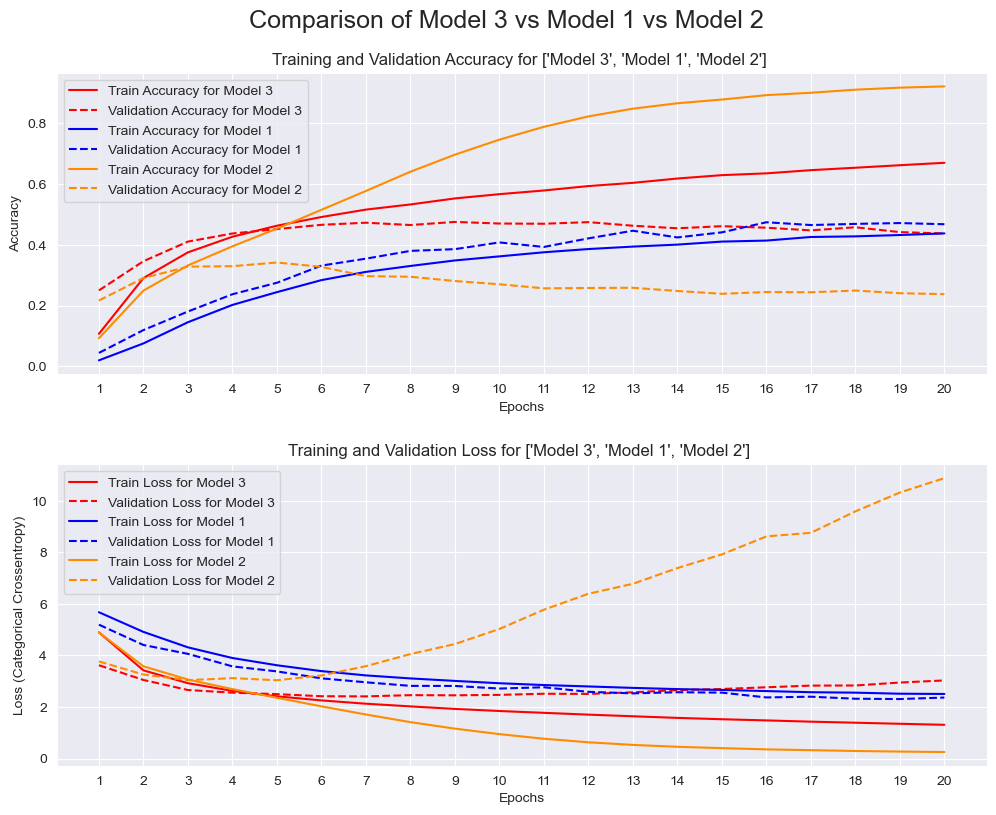

In [65]:
# Inspecting the validation scores - notice Model 1 seemed to have the most promise surprisingly

compare_models_same_plot([model3_df, first_model, model_df], val_only=False, train_only=False)

<hr style="border:4px solid blue">

### Model 4 with Weights and Biases Callback/Dashboard
This will be our most ambitious attempt to create something resembling a true EfficientNet architecture. This model includes depthwise convolutional layers, and squeeze-excite blocks. Depthwise convolution involves a single kernel for each feature map being convolved over its respective feature map. If there were 10 feature maps as the output of the previous layer, then 10 unique kernels would be initiated, and only 1 would be used on a given feature map. 

Squeeze-excite blocks utilize a Global Average Pooling layer to condense or `squeeze` the current model output into 1 average value for each feature map, and assign that value to a new variable. This variable is processed by two Dense layers in my model, before being multiplied to the input volume of our data, thereby `exciting` it. This "excitation" helps emphasize significant channel-wise information, adding to the model's ability to predict accurately.

You may also notice the inclusion of "phi" and "rho" in the function definition below. `Phi` is the term that governs the `"width"` of the network. This refers to the number of channels/filters/kernels in the different convolutional layers. Increasing phi results in a wider network with more channels in each layer. This allows the model to capture more complex patterns and features from the image data. A larger value of phi typically leads to a larger number of parameters and computational cost but may improve the model's ability to learn complex patterns in the data. A smaller value of phi reduces the model's capacity but also helps to limit computational demands placed on your system.

`Rho` controls the `"depth"` of the network. This describes  the number of layers in the model. Once again, increasing rho results in a deeper network with more layers, enabling the model to capture more abstract features from the input data. Once again, a larger value of rho typically corresponds to a larger number of parameters and computational cost but may improve the model's ability to learn.

Again, we were limited here by the computational power required for training these networks, and we were unable to train a model of tremendous depth or width. The trajectory of this model's metrics were nearest our first model, which actually was the least over-fit, but also did not manage the most impressive accuracy scores. 

In [9]:
# Function for creating my model

def efficient_net(input_shape=(224, 224, 3), num_classes=525, phi=1.0, rho=1.0):
    model = Sequential()

    ## Depth Scaling ##
    # Adjust the number of layers based on the depth scaling coefficient (phi)
    # The scaling factor determines the number of layers in the model
    num_layers = round(3.0 * phi)  # Adjust scaling factor as needed

    # Initial Convolutional Layer
    model.add(Conv2D(filters=round(32 * rho), kernel_size=(3, 3), strides=2, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    ## Blocks (Repeat similar blocks) ##
    # Repeat similar blocks consisting of depthwise separable convolution, batch normalization, activation, and 
    # squeeze-excite operations. Each block contributes to the overall depth and complexity of the model
    
    for _ in range(num_layers):
        # Depthwise Separable Convolution
        model.add(DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same', depth_multiplier=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        # Pointwise Convolution (1x1)
        model.add(Conv2D(filters=round(64 * rho), kernel_size=(1, 1), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        if _ % 2 == 1:
            ## Squeeze-excite blocks
            
            # Generate a tensor representing channel-wise statistics by applying Global Average Pooling to the 
            # output feature maps of the preceding layers. This tensor captures the global information for 
            # each channel.
            squeeze_excite = GlobalAveragePooling2D()(model.output)  # THIS IS THE SQUEEZE

            # Run the new tensor through a Dense fully connected layer
            squeeze_excite = Dense(round(64 * rho // 16), activation='relu')(squeeze_excite)

            # Run that through a second Dense Fully Connected layer
            squeeze_excite = Dense(round(64 * rho), activation='sigmoid')(squeeze_excite)

            # Multiply the output tensor from the preceding layers by the computed squeeze-excite tensor 
            # element-wise. This operation enhances the channel-wise features and updates the model output to 
            # this point
            squeeze_excite = Multiply()([model.output, squeeze_excite])

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())
    
    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate the EfficientNet-B0 model with desired scaling coefficients
efficientnet = efficient_net(phi=1.0, rho=1.0)

# Display model summary
efficientnet.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_13 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d_6 (Depthwi  (None, 112, 112, 32)     320       
 seConv2D)                                                       
                                                                 
 batch_normalization_14 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                      

In [18]:
# Model training with Weights and Biases Callback to use the dashboard

wandb.init(
    # Title the project for WandB documentation
    project="Bird Species Classification",
    
    # Record the setup of the network - only for documentation purposes
    config={"architecture":"CNN",
            "dataset":"Kaggle 525 Species Classification",
            "epochs":5,
            "blocks":3,
            "pre-processing":"scaling(1/255)",
            "typical_block_composition":["input_cnn", "BatchNorm"],
            "final_block":["GlobAvgPool, flatten, dense_output"]
}
          )

# Compile the model
efficientnet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Store history of training in a variable
history_4 = efficientnet.fit(train_generator, epochs=5, validation_data=valid_generator, workers=6,\
                       callbacks=[WandbCallback()])

# Terminate the callback
wandb.finish()

Epoch 1/5
2645/2645 [==============================] - ETA: 0s - loss: 5.4363 - accuracy: 0.0429

INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets
wandb: Adding directory to artifact (/Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best)... Done. 0.0s


2645/2645 [==============================] - 6341s 2s/step - loss: 5.4363 - accuracy: 0.0429 - val_loss: 5.2277 - val_accuracy: 0.0678
Epoch 2/5
2645/2645 [==============================] - ETA: 0s - loss: 4.4949 - accuracy: 0.1222

INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets
wandb: Adding directory to artifact (/Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best)... Done. 0.0s


2645/2645 [==============================] - 5508s 2s/step - loss: 4.4949 - accuracy: 0.1222 - val_loss: 4.5154 - val_accuracy: 0.1128
Epoch 3/5
2645/2645 [==============================] - ETA: 0s - loss: 4.0138 - accuracy: 0.1851

INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets
wandb: Adding directory to artifact (/Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best)... Done. 0.0s


2645/2645 [==============================] - 9574s 4s/step - loss: 4.0138 - accuracy: 0.1851 - val_loss: 3.7698 - val_accuracy: 0.2091
Epoch 4/5
2645/2645 [==============================] - ETA: 0s - loss: 3.6792 - accuracy: 0.2339 

INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets
wandb: Adding directory to artifact (/Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best)... Done. 0.0s


2645/2645 [==============================] - 36406s 14s/step - loss: 3.6792 - accuracy: 0.2339 - val_loss: 3.6196 - val_accuracy: 0.2530
Epoch 5/5
2645/2645 [==============================] - ETA: 0s - loss: 3.4377 - accuracy: 0.2695

INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best/assets
wandb: Adding directory to artifact (/Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240215_182134-miehberp/files/model-best)... Done. 0.0s


2645/2645 [==============================] - 5735s 2s/step - loss: 3.4377 - accuracy: 0.2695 - val_loss: 3.3243 - val_accuracy: 0.2865


accuracy,▁▃▅▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▂▆▇█
val_loss,█▅▃▂▁
accuracy,0.26951
best_epoch,4
best_val_loss,3.32432
epoch,4
loss,3.43766
val_accuracy,0.28648


In [61]:
# Model Evaluation, history conversion to dataframe, saving model
# model4_df = pd.DataFrame(history_4.history)

# model4_df["Name"] = "Model 4"
# model4_df["Epochs"] = range(1, 6)

# model4_df.to_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_4_logs.csv')
model4_df = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_4_logs.csv', index_col=0)

# history_4.model.save() # Choosing not to save the model, because its performance was poor
model4_df.head()

,loss,accuracy,val_loss,val_accuracy,Name,Epochs
0,5.436254,0.042914,5.227713,0.067810,Model 4,1
1,4.494897,0.122195,4.515403,0.112762,Model 4,2
2,4.013810,0.185148,3.769755,0.209143,Model 4,3
3,3.679219,0.233875,3.619551,0.252952,Model 4,4
4,3.437663,0.269510,3.324319,0.286476,Model 4,5


### Performance Evaluation

In [38]:
# Evaluate performance on test data: 30.5% accurate

history_4.model.evaluate(test_generator)

83/83 [==============================] - 39s 471ms/step - loss: 3.2291 - accuracy: 0.3051


[3.2291250228881836, 0.3051428496837616]

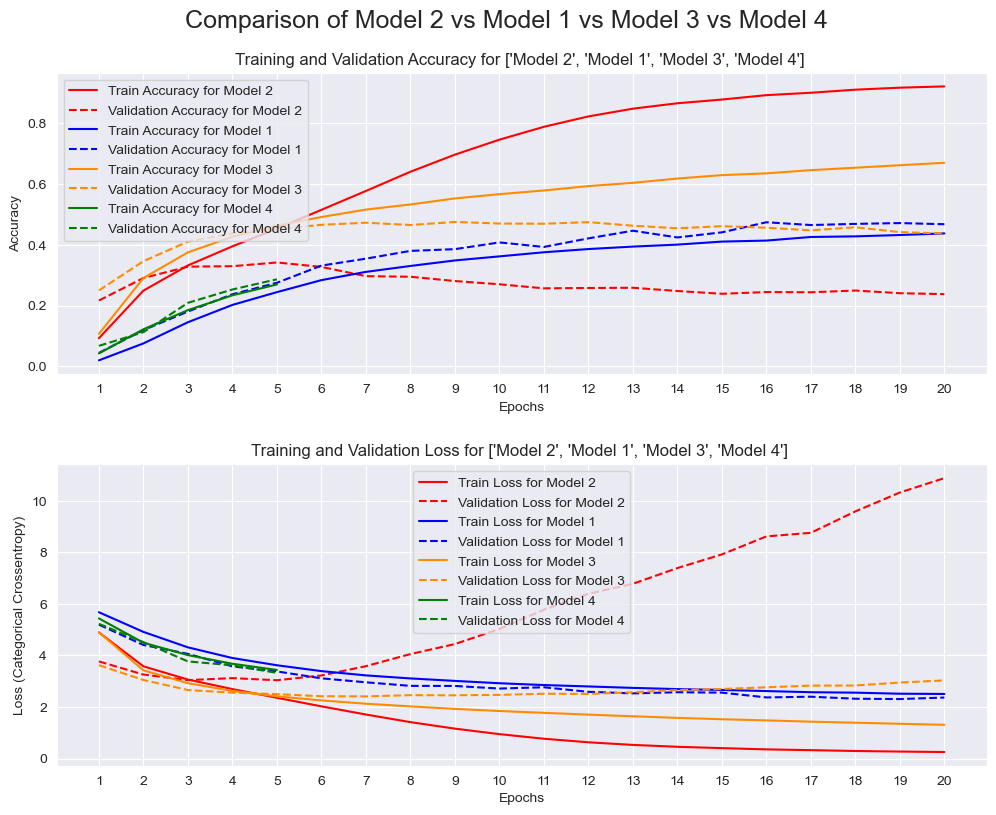

In [66]:
# Plotting performance - the trajectory of the model was not very favorable compared to previous model

compare_models_same_plot([model_df, first_model, model3_df, model4_df])

<hr style="border:4px solid blue">

### Utilizing the pre-trained model provided by kaggle - EfficientNetB0
Here, we will take the EfficientNetB0 model provided by kaggle, and we will customize it slightly. This allows us to leverage the pre-existing design and training of the model. The only steps needed to modify the model are to remove the final Dense layers from the pre-trained model, set the preserved model's layers "layer.trainable = False", and to define the final output layers.  

In [1]:
from tensorflow.keras.models import load_model

provided_model = load_model('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/EfficientNetB0-525-(224 X 224)- 98.97.h5',
                           custom_objects={"F1_score":"F1_score"})

In [30]:
### Detaching the output layers from the model, and customizing my own output layers

# Removing the final 3 layers which were as follows... 
my_model = Model(inputs=provided_model.input, outputs=provided_model.layers[-3].output)

# dense (Dense)                  (None, 256)          327936      ['batch_normalization[0][0]']                                                                                                      
#  dropout (Dropout)              (None, 256)          0           ['dense[0][0]']                                                                                                                   
#  dense_1 (Dense)                (None, 525)          134925      ['dropout[0][0]']       


# Preventing the re-training of the weights from the imported model
for layer in my_model.layers:
    layer.trainable = False
    

# Defining my custom layers
x = Dense(256, activation='relu', name="Dense_1")(my_model.output)
x = Dropout(0.4, seed=13)(x)
x = Dense(125, activation='relu', name="Dense_2")(x)
x = Dropout(0.4, seed=13)(x)

# Output layer
output = Dense(525, activation='softmax', name="Dense_Output")(x)

# Instantiate the final model
final_model = Model(inputs=my_model.input, outputs=output)

In [32]:
# Model compilation

final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

<hr style="border: 2px solid blue">

##### Data Generator settings - a repetition of an earlier cell, but removing the rescaling within the generator

In [33]:
# Local path containing train/valid/test folders

path = "/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive"

image_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rescale=None,  # This argument is changed to leave data as is, and will be rescaled in first layers
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",  # still the same
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None)

In [34]:
# Train Generator
train_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "train"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

# Validation
valid_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "valid"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

#Test
test_generator = image_generator.flow_from_directory(
    directory=os.path.join(path, "test"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    seed=13
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [41]:
# Callbacks (Weights and Biases addressed in previous models)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs

early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5, # if val loss doesn't improve over 5 epochs...
                               restore_best_weights = True) 
                            # if val loss increases for 5 epochs in a row, stop training


# Setup decaying Learning rate on plateau if metrics indicate the approach of a local bottom

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [42]:
# Model Training

wandb.init(
    # Title the project
    project="Bird Species Classification",
    
    # Record the setup of the network
    config={"architecture":"Loaded Model",
            "dataset":"Kaggle 525 Species Classification",
            "epochs":60,
            "blocks":"A Lot",
            "pre-processing":"All done in model",
            "typical_block_composition": "EfficientNet",
            "final_block":["Dense, Dropout, Dense, Dropout, dense_output"]
}
          )

final_history = final_model.fit(train_generator, validation_data = valid_generator, epochs = 60, \
                                callbacks=[WandbCallback(), early_stopping, reduce_lr], workers=-1)

wandb.finish()

Epoch 1/60
2645/2645 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.9092

INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240217_173600-34ihiq2p/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240217_173600-34ihiq2p/files/model-best/assets
wandb: Adding directory to artifact (/Users/samalainabayeva/Documents/Flatiron/Bird_Species_Classification/Bird_Species_Image_Classification/wandb/run-20240217_173600-34ihiq2p/files/model-best)... Done. 0.1s


2645/2645 [==============================] - 2123s 803ms/step - loss: 0.7047 - accuracy: 0.9092 - val_loss: 0.4941 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 2/60
2645/2645 [==============================] - 2043s 773ms/step - loss: 0.2479 - accuracy: 0.9889 - val_loss: 0.5492 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 3/60
2645/2645 [==============================] - 3041s 1s/step - loss: 0.2350 - accuracy: 0.9913 - val_loss: 0.5865 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 4/60
2645/2645 [==============================] - 2711s 1s/step - loss: 0.2304 - accuracy: 0.9918 - val_loss: 0.6148 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/60
2645/2645 [==============================] - 1952s 738ms/step - loss: 0.2179 - accuracy: 0.9955 - val_loss: 0.6211 - val_accuracy: 0.9764 - lr: 2.0000e-04
Epoch 6/60
2645/2645 [==============================] - 4444s 2s/step - loss: 0.2140 - accuracy: 0.9968 - val_loss: 0.6263 - val_accuracy: 0.9760 - lr: 2.0000e-04


accuracy,▁▇████
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
val_accuracy,▁▃▆▃█▆
val_loss,▁▄▆▇██
accuracy,0.99685
best_epoch,0
best_val_loss,0.49407
epoch,5
loss,0.21396
val_accuracy,0.976


### Early Stopping
The val_loss score did not improve for 5 consecutive epochs, so the training was stopped considerably early. The performance metrics were already extremely impressive. Validation accuracy was nearly 98% on each training run. This model is certainly performing at a level that would be difficult to improve upon.

In [44]:
# Train Data Evaluation

final_model.evaluate(train_generator)

2645/2645 [==============================] - 2426s 917ms/step - loss: 0.2065 - accuracy: 0.9991


[0.20649157464504242, 0.9991138577461243]

In [45]:
# Validation Data Evaluation - worst predictive performance of the group

final_model.evaluate(valid_generator)

83/83 [==============================] - 53s 636ms/step - loss: 0.4941 - accuracy: 0.9752


[0.4940686821937561, 0.9752380847930908]

In [43]:
# Test Data Evaluation

final_model.evaluate(test_generator)

83/83 [==============================] - 55s 666ms/step - loss: 0.3124 - accuracy: 0.9890


[0.3123658299446106, 0.9889523983001709]

In [52]:
# Model df creation for record keeping

# final_model_df = pd.DataFrame(final_history.history)
# final_model_df["Name"] = "Final Model"
# final_model_df["Epochs"] = range(1, 7)
# final_model_df.to_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_FINAL_logs.csv')
final_model_df = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/model_FINAL_logs.csv', \
                             index_col=0)
final_model_df

,loss,accuracy,val_loss,val_accuracy,lr,Name,Epochs
0,0.704748,0.909186,0.494069,0.975238,0.0010,Final Model,1
1,0.247905,0.988905,0.549173,0.975619,0.0010,Final Model,2
2,0.234992,0.991257,0.586453,0.976000,0.0010,Final Model,3
3,0.230393,0.991836,0.614836,0.975619,0.0010,Final Model,4
4,0.217947,0.995534,0.621118,0.976381,0.0002,Final Model,5
5,0.213964,0.996845,0.626334,0.976000,0.0002,Final Model,6


In [53]:
# Save the model for deployment

final_model.save('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/models/FINAL_bird_classifier_2.h5')

# Load model for later use if necessary 
final_model = load_model('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/models/FINAL_bird_classifier_2.h5')

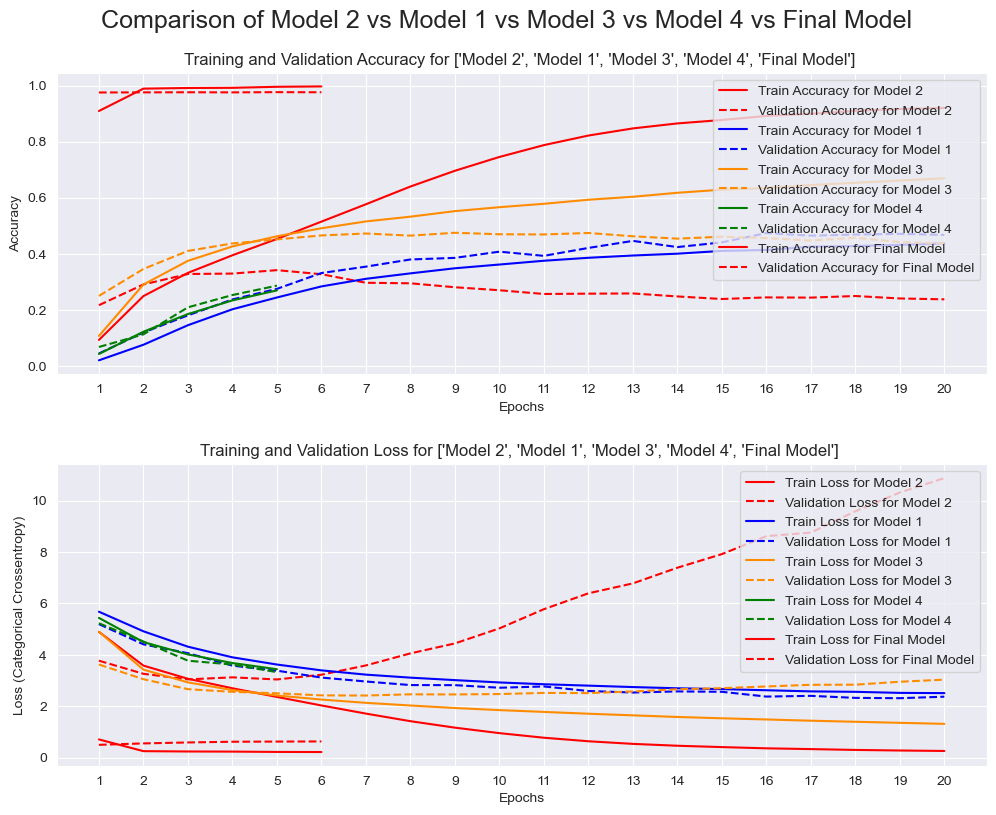

In [67]:
# Plotting performance - the final model is near perfect, and incomparable to the earlier models
compare_models_same_plot([model_df, first_model, model3_df, model4_df, final_model_df])

### First "Wild" Image

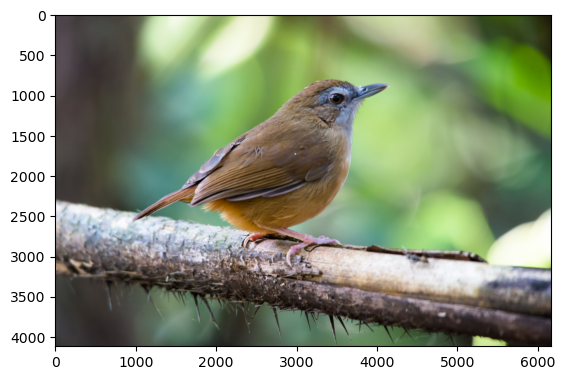

1/1 [==============================] - 0s 70ms/step


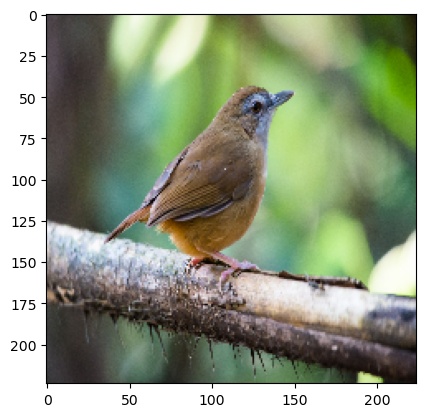

In [107]:
plt.style.use("default")

# Read in the image
img = mpimg.imread(os.path.join(path, "unseen_images", "abbots_babbler.jpg"))

# Image with dimensions and appearance exactly as downloaded
plt.imshow(img)
plt.show();

# tf.image.resize(<image>, <(*new_pixel_dims)>)
resized_image = tf.image.resize(img, (224,224))

# Plot re-sized image
plt.imshow(resized_image.numpy().astype(int));

# Getting the model to generate a prediction by using np.expand_dims() to deal with the issue of batch size
y_pred = final_model.predict(np.expand_dims(resized_image, 0))

In [96]:
# The maximum value for the prediction of the 0th element of the prediction batch is the class number

# This prediction is of and extremely high value -> .99999

np.argmax(y_pred), y_pred[0, 0:4]

(0,
 array([9.9999535e-01, 1.8791830e-12, 9.3540960e-11, 2.1247682e-12],
       dtype=float32))

In [93]:
# The number - to - name dictionary index

reverse_dict[0]

'ABBOTTS BABBLER'

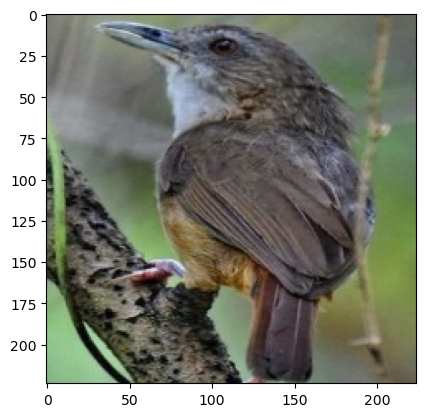

In [105]:
abbotts = plt.imread('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/train/ABBOTTS BABBLER/006.jpg')
plt.imshow(abbotts);

In [97]:
# Sanity Check

train_generator.class_indices['ABBOTTS BABBLER']

0

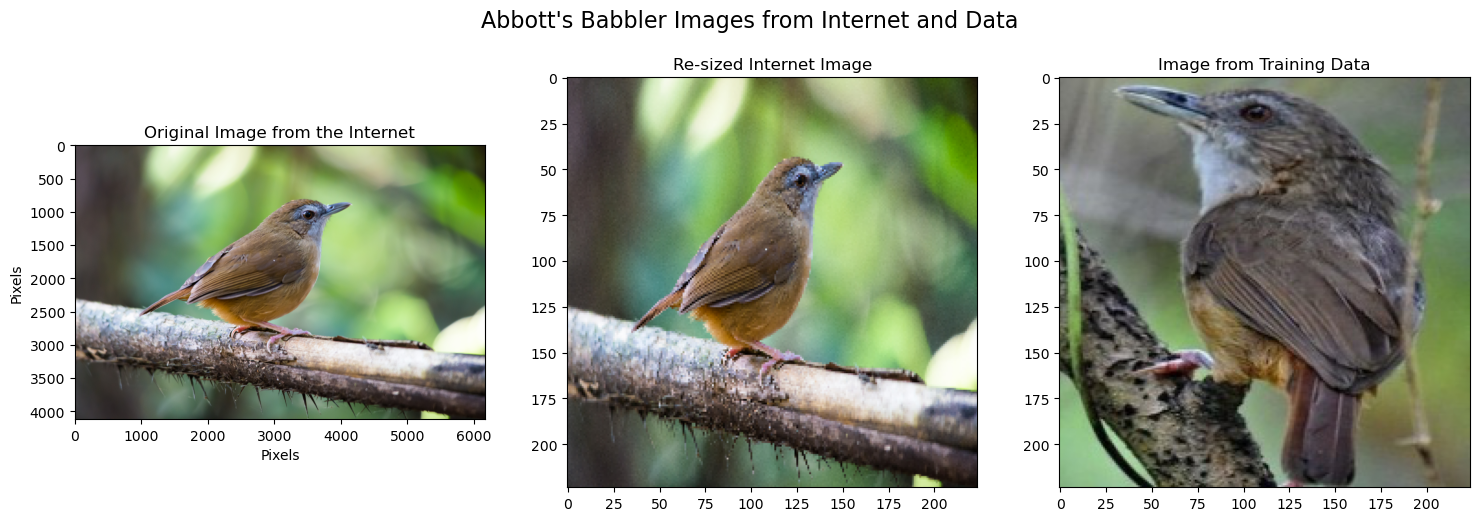

In [123]:
# Showing the whole image resizing process and a representative training image
fig, ax = plt.subplots(ncols=3, figsize=(18,6), sharey=False)

# Raw internet image
ax[0].imshow(img)
ax[0].set_title("Original Image from the Internet")

# Re-sized image
ax[1].imshow(resized_image.numpy().astype(int))
ax[1].set_title("Re-sized Internet Image")

# Training image
ax[2].imshow(abbotts)
ax[2].set_title("Image from Training Data")

# Title and one set of ax labels
plt.suptitle("Abbott's Babbler Images from Internet and Data", y=.95, fontsize=16)
ax[0].set_xlabel("Pixels")
ax[0].set_ylabel("Pixels");

### 2nd Wild Image

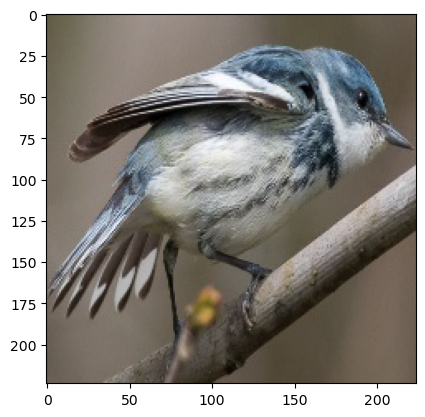

In [99]:
# This is the image from the training data

cerulean_warbler = plt.imread('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/train/CERULEAN WARBLER/001.jpg')
plt.imshow(cerulean_warbler);

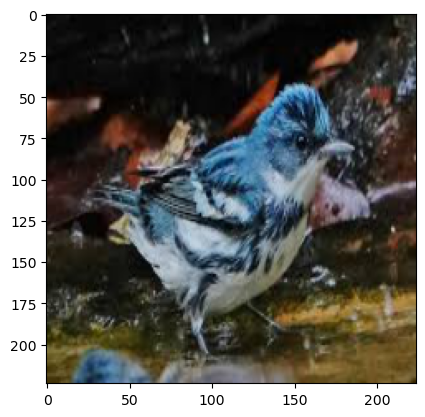

1/1 [==============================] - 0s 65ms/step


137

In [104]:
# Load in the image from the internet

cer_imp = plt.imread('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/unseen_images/cerulean_warbler.jpg')

# Reshape the image to conform to input shape
cer_resized = tf.image.resize(cer_imp, (224,224))

# plot the image
plt.imshow(cer_resized.numpy().astype(int))
plt.show()

# Generate a prediction using np.expand_dims to account for the batch size issues
y_pred = final_model.predict(np.expand_dims(cer_resized, 0))

# The maximum value for the prediction of the 0th element of the prediction batch is the class number
np.argmax(y_pred[0])

In [102]:
# Another correct prediction from the wild!

reverse_dict[137], y_pred[0, 135:139]

('CERULEAN WARBLER',
 array([9.9758239e-08, 2.1391470e-13, 9.9997103e-01, 2.9276047e-14],
       dtype=float32))

<hr style="border: 4px solid blue">

### Conclusion
Our attempts to create a high-performance model achieved moderate results, but they were nowhere as accurate as the EfficientNetB0 architecture. With very little adaptation, this model produced extremely high accuracy scores on the images from our dataset. There is still more to learn about how the model's depth, width, and resolution are calibrated, but we have learned a great deal about EfficientNet architecture through this project, and look forward to future study as well. 

This model has performed extremely well on the train, validation, and test data. Also, early returns on unseen data from the Internet is also fairly impressive. Although reshaping of images taken from "the wild", thereby distorting them slightly, is required in order to pass the images through the model, the prediction of the first two images taken from "the wild" were still correct. The spacial distortion of reshaping the images has not interfered with model accuracy in this small sample.

The final phase of this project will involve model deployment using the Streamlit platform. There, a basic application will be deployed that allows users to input images of birds (of one of the 525 classes from this project) and evaluate model predictions. 